# Tutorial 2: scRNA and ST data integration (deconvolution)

In [1]:
import scanpy as sc
from DeepST import DeepST

In [2]:
dataset = '151673'

In [3]:
# set random seed
random_seed = 50 
DeepST.fix_seed(random_seed)

In [4]:
# read ST data
file_fold = '/home/yahui/Yahui/Projects/data/' + str(dataset)
adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()

/home/yahui/anaconda3/envs/long/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
# preprocessing for ST data
DeepST.preprocess(adata)

# built graph
DeepST.construct_interaction(adata)
DeepST.add_contrastive_label(adata)

In [6]:
# read scRNA daa
file_path = '/home/yahui/anaconda3/work/CellCluster_DEC/data/' + str(dataset) + '/scRNA.h5ad' 
adata_sc = sc.read(file_path)
adata_sc.var_names_make_unique()

In [7]:
# preprocessing for scRNA data
DeepST.preprocess(adata_sc)

In [8]:
# find overlap genes
from DeepST.preprocess import filter_with_overlap_gene
adata, adata_sc = filter_with_overlap_gene(adata, adata_sc)

Number of overlap genes: 750


/home/yahui/anaconda3/envs/long/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [9]:
# get features
DeepST.get_feature(adata)

print('adata:', adata)
print('adata_sc:', adata_sc)

adata: AnnData object with n_obs × n_vars = 3639 × 750
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p', 'overlap_genes'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a'
adata_sc: View of AnnData object with n_obs × n_vars = 78886 × 750
    obs: 'cell_type'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'overlap_genes'


In [10]:
# Train model
model = DeepST.Train(adata, adata_sc, epochs=1200, deconvolution=True)
adata, adata_sc = model.train_map()

Begin to train ST data...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 83.07it/s]


Optimization finished for ST data!
Begin to train scRNA data...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:13<00:00, 92.03it/s]


Optimization finished for cell representation learning!
Begin to learn mapping matrix...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [01:34<00:00, 12.64it/s]


Mapping matrix learning finished!


adata: AnnData object with n_obs × n_vars = 3639 × 750
    obs: 'in_tissue', 'array_row', 'array_col', 'Astros_1', 'Astros_2', 'Astros_3', 'Endo', 'Ex_10_L2_4', 'Ex_1_L5_6', 'Ex_2_L5', 'Ex_3_L4_5', 'Ex_4_L_6', 'Ex_5_L5', 'Ex_6_L4_6', 'Ex_7_L4_6', 'Ex_8_L5_6', 'Ex_9_L5_6', 'Inhib_1', 'Inhib_2_VIP', 'Inhib_3_SST', 'Inhib_4_SST', 'Inhib_5', 'Inhib_6_SST', 'Inhib_7_PVALB', 'Inhib_8_PVALB', 'Micro/Macro', 'Mix_1', 'Mix_2', 'Mix_3', 'Mix_4', 'Mix_5', 'OPCs_1', 'OPCs_2', 'Oligos_1', 'Oligos_2', 'Oligos_3'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p', 'overlap_genes'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb_sp', 'map_matrix'


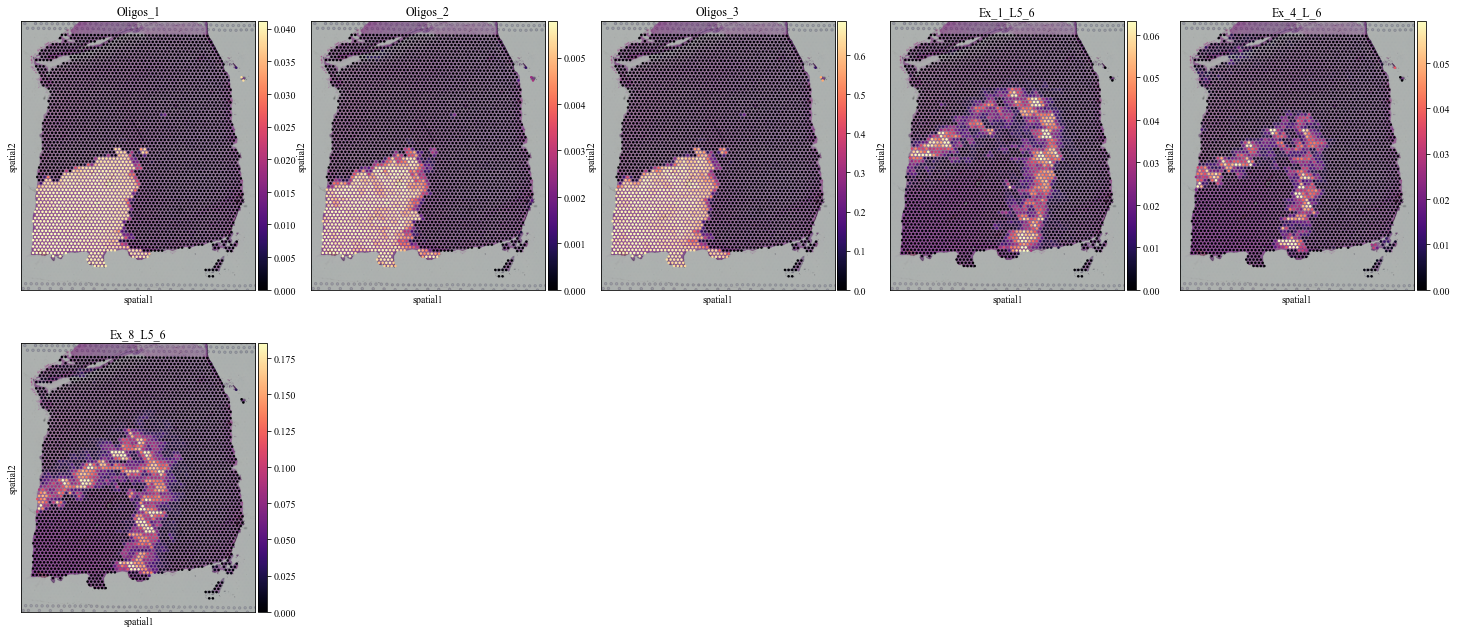

In [14]:
# Project cells into spatial space
from DeepST.utils import project_cell_to_spot
celltype = ['Oligos_1', 'Oligos_2', 'Oligos_3', 
                           'Ex_1_L5_6', 'Ex_4_L_6', 'Ex_8_L5_6'] # cell types you want to see
project_cell_to_spot(adata, adata_sc, celltype)